In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

from qtt.algorithms.functions import (gauss_ramsey, fit_gauss_ramsey, 
                                      plot_gauss_ramsey_fit)
from qutip import (basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, 
                   mesolve, identity, Qobj, destroy, qeye, expect, parallel_map)

from qubit_zz_coupling.core import (setup_operators, solve_t1, solve_t2,
                                    plot_t1, plot_t2, rabi_results, make_n,
                                    ramsey_expectation_drive_both,
                                    ramsey_population_drive_both,
                                    ramsey_expectation_drive_sep,
                                    ramsey_population_drive_sep,
                                    make_3tensor, ramsey_result,
                                    ramsey_result_multiplex,
                                    rabi_results_multiplex)
from qubit_zz_coupling.utils import  f2w, fq_shift, make_population, ramsey


In [6]:
USE_MP = True # Depends on system

# Define system parameters
SYSTEM_PARAMS_base = {
    "f_q1": 3.200,  # GHz, Qubit 1 frequency (3.2)
    "f_q2": 3.250,  # GHz, Qubit 2 frequency
    "f_tls": 3.200,  # GHz, TLS frequency (resonant with Qubit 1)
    "T1": {"q1": 20000, "q2": 25000, "tls": 1e8},  # Relaxation rates 200
    "T2": {"q1": 15000, "q2": 18000, "tls": 1e8},  # Dephasing rates 150
    "J_zz": 0.01, # Jzz coupling
    "J_tls": 0.00,  # GHz, Coupling strength between Qubit 1 and TL
    "omega1": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "omega2": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "time_points": np.linspace(0, 300, 105),  # Time points in μs
    "ver1": True,
    "single": False
}

opts = {"nsteps": 1000000, "store_final_state":False, "atol":1e-10,"rtol":1e-8}

# Ramsey Oscillation

In [7]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])
w_q2 = f2w(SYSTEM_PARAMS["f_q2"])

w_d = w_q1 + f2w(0.01)
omega = SYSTEM_PARAMS["omega1"]

# Example sweep
taus      = np.linspace(0, 40000, 64)
t_p = np.pi / (2*SYSTEM_PARAMS["omega1"])


H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

def pm(t):
    res_psi = ramsey_result(t, w_d, t_p, omega, H, sx_q1, c_ops, opts=opts, psi0=make_3tensor(0,0,1), step=1) # ramsey must start in 0 i think
    n = make_n(sm_q1)
    res = expect(n, res_psi)
    return res 

if  USE_MP:
    vals = list(parallel_map(pm,taus,progress_bar=True))
else:
    vals = [pm(tau) for tau in taus]


10.9%. Run time:   5.77s. Est. time left: 00:00:00:46
20.3%. Run time:   8.24s. Est. time left: 00:00:00:32
31.2%. Run time:  10.56s. Est. time left: 00:00:00:23
40.6%. Run time:  16.38s. Est. time left: 00:00:00:23
50.0%. Run time:  18.16s. Est. time left: 00:00:00:18
60.9%. Run time:  20.69s. Est. time left: 00:00:00:13
70.3%. Run time:  23.23s. Est. time left: 00:00:00:09
81.2%. Run time:  25.23s. Est. time left: 00:00:00:05
90.6%. Run time:  26.47s. Est. time left: 00:00:00:02
100.0%. Run time:  29.37s. Est. time left: 00:00:00:00
Total run time:  29.49s


Text(0, 0.5, 'Population')

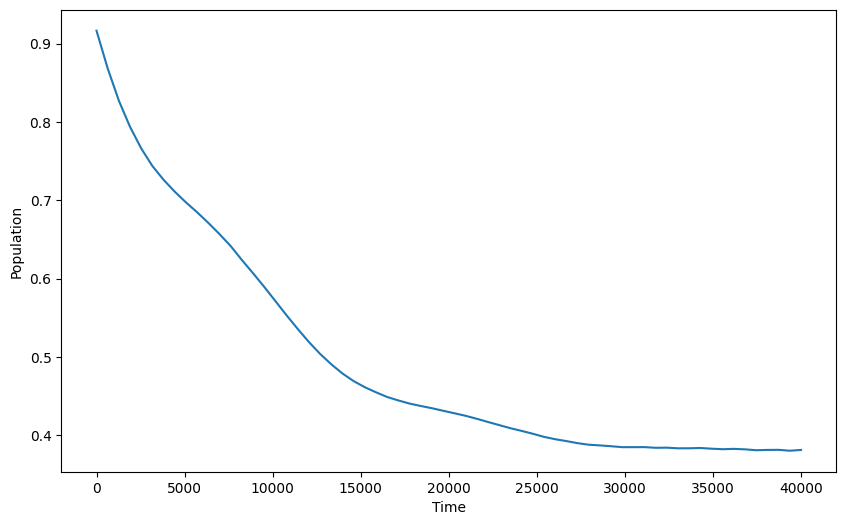

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

#axes.scatter(t[i],res[i],color="red") #pi pulse peak
axes.plot(taus, vals)
axes.set_xlabel('Time')
axes.set_ylabel('Population')
#axes.set_title(f'Rabi Oscillation pulse={pi_pulse:.3f}');

In [9]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])
omega = SYSTEM_PARAMS["omega1"]

# Example sweep
#taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

def pm(arg):
    res_psi = ramsey_result(arg[0], arg[1], t_p, omega, H, sx_q1, c_ops, opts=opts, psi0=make_3tensor(0,0,0))
    n = make_n(sm_q1)
    res = expect(n, res_psi)
    return res 

# interrogation times and detunings
T=np.linspace(0,4000,64) # ns 128
#Det_p=np.linspace(-0.002,0.002,64) # no coup
#Det_p=np.linspace(-0.006,-0.003,64) # coup tls
Det_p=np.linspace(-0.018,-0.014,64) # coup tls and q2
Det=f2w(Det_p)+w_q1 # GHz

# generates pairs for each coordinate and puts them in a 1D list
T,Det=np.meshgrid(T,Det)
pairs=np.array([T.flatten(),Det.flatten()]).T

if  USE_MP:
    vals = list(parallel_map(pm,pairs,progress_bar=True))
else:
    vals = [pm(pair) for pair in pairs]

# reshapes the list of results into a matrix
rmap=np.array(vals).reshape(T.shape)

10.0%. Run time:  15.24s. Est. time left: 00:00:02:16
20.0%. Run time:  29.59s. Est. time left: 00:00:01:58
30.0%. Run time:  43.65s. Est. time left: 00:00:01:41
40.0%. Run time:  57.72s. Est. time left: 00:00:01:26
50.0%. Run time:  71.62s. Est. time left: 00:00:01:11
60.0%. Run time:  85.94s. Est. time left: 00:00:00:57
70.0%. Run time: 100.11s. Est. time left: 00:00:00:42
80.0%. Run time: 114.23s. Est. time left: 00:00:00:28
90.0%. Run time: 128.41s. Est. time left: 00:00:00:14
100.0%. Run time: 142.98s. Est. time left: 00:00:00:00
Total run time: 143.19s


Text(0, 0.5, 'Population')

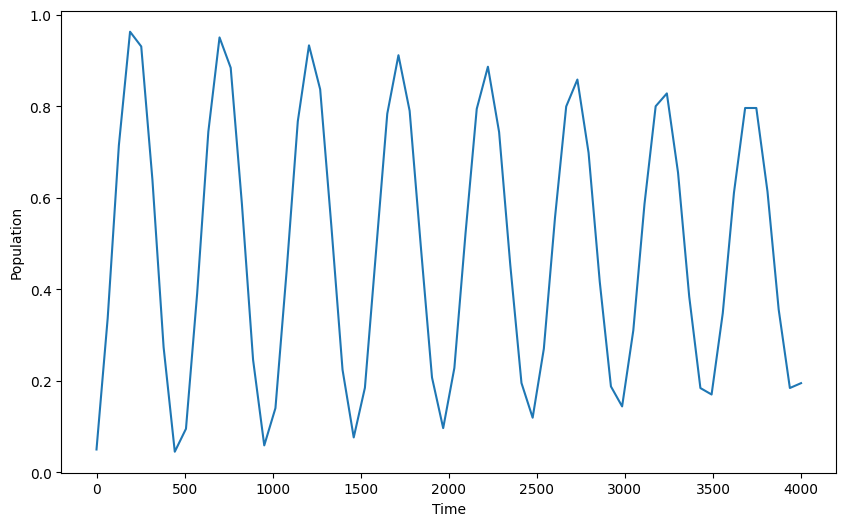

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

#axes.scatter(t[i],res[i],color="red") #pi pulse peak
axes.plot(np.linspace(0,4000,64), vals[0:64])
axes.set_xlabel('Time')
axes.set_ylabel('Population')
#axes.set_title(f'Rabi Oscillation pulse={pi_pulse:.3f}');

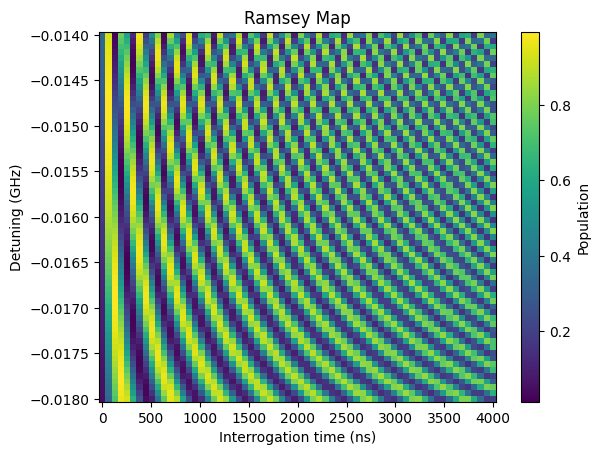

In [13]:

# prompt: Plot exp pcolor map with T and Det as axis


# Assuming T and Det and exp are defined from the previous code block
plt.pcolormesh(T, Det_p, rmap)
plt.xlabel("Interrogation time (ns)")
plt.ylabel("Detuning (GHz)")
plt.title("Ramsey Map")
plt.colorbar(label="Population")
plt.show()

# Multiplex drive

In [89]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])
w_q2 = f2w(SYSTEM_PARAMS["f_q2"])

#w_d = w_q1 + f2w(0.001)
w_d = w_q1 
omega = SYSTEM_PARAMS["omega1"]*f2w(w_d)
#omega = 

# Example sweep
taus      = np.linspace(0, 4000, 100)
#t_p = np.pi / (2*SYSTEM_PARAMS["omega1"])
t_p = np.pi / (2 * w_q1)

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

def pm(t):
    #res_psi = ramsey_result_multiplex(t, w_q1+f2w(0.002),  w_q2+f2w(0.002), t_p, omega, H, sx_q1, sx_q2, c_ops, opts=opts, psi0=make_3tensor(0,0,0))
    res_psi = ramsey_result(t, w_q1+f2w(0.002), t_p, omega, H, sx_q1, c_ops, opts=opts, psi0=make_3tensor(1,0,0), step=1)
    n = make_n(sm_q1)
    res = expect(n, res_psi)
    return res 

if  USE_MP:
    vals = list(parallel_map(pm,taus,progress_bar=True))
else:
    vals = [pm(tau) for tau in taus]

10.0%. Run time:   1.26s. Est. time left: 00:00:00:11
20.0%. Run time:   1.79s. Est. time left: 00:00:00:07
30.0%. Run time:   2.28s. Est. time left: 00:00:00:05
40.0%. Run time:   2.71s. Est. time left: 00:00:00:04
50.0%. Run time:   3.24s. Est. time left: 00:00:00:03
60.0%. Run time:   3.62s. Est. time left: 00:00:00:02
70.0%. Run time:   3.98s. Est. time left: 00:00:00:01
80.0%. Run time:   4.25s. Est. time left: 00:00:00:01
90.0%. Run time:   4.49s. Est. time left: 00:00:00:00
100.0%. Run time:   4.90s. Est. time left: 00:00:00:00
Total run time:   5.02s


Text(0, 0.5, 'Population')

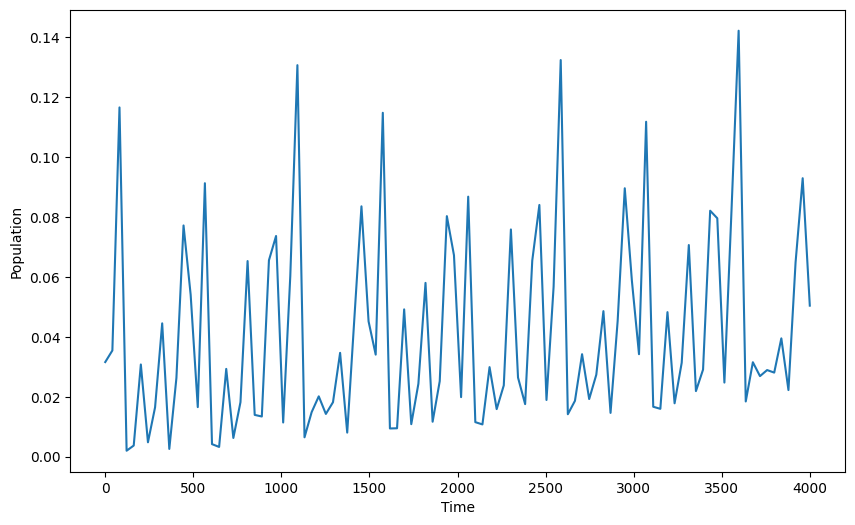

In [90]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

#axes.scatter(t[i],res[i],color="red") #pi pulse peak
axes.plot(taus, vals)
axes.set_xlabel('Time')
axes.set_ylabel('Population')
#axes.set_title(f'Rabi Oscillation pulse={pi_pulse:.3f}');

In [45]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

w_q1 = f2w(SYSTEM_PARAMS["f_q1"])
w_q2 = f2w(SYSTEM_PARAMS["f_q2"])

w_d = w_q1 + f2w(0.00)
omega = SYSTEM_PARAMS["omega1"]

# Example sweep
taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

def pm(arg):
    res_psi = ramsey_result_multiplex(arg[0], arg[1],  w_q2+f2w(0.04), t_p, omega, H, sx_q1, sx_q2, c_ops, opts=opts, psi0=make_3tensor(1,1,0))
    n = make_n(sm_q1)
    res = expect(n, res_psi)
    return res 

# interrogation times and detunings
T=np.linspace(0,4000,20) # ns
Det_p=np.linspace(0.038,0.042,20) # GHz
Det=f2w(Det_p)+w_q1 # GHz

# generates pairs for each coordinate and puts them in a 1D list
T,Det=np.meshgrid(T,Det)
pairs=np.array([T.flatten(),Det.flatten()]).T

if  USE_MP:
    vals = list(parallel_map(pm,pairs,progress_bar=True))
else:
    vals = [pm(pair) for pair in pairs]

# reshapes the list of results into a matrix
rmap=np.array(vals).reshape(T.shape)

10.0%. Run time:   4.95s. Est. time left: 00:00:00:44
20.0%. Run time:   8.43s. Est. time left: 00:00:00:33
30.0%. Run time:  11.54s. Est. time left: 00:00:00:26
40.0%. Run time:  13.82s. Est. time left: 00:00:00:20
50.0%. Run time:  16.86s. Est. time left: 00:00:00:16
60.0%. Run time:  19.74s. Est. time left: 00:00:00:13
70.0%. Run time:  22.75s. Est. time left: 00:00:00:09
80.0%. Run time:  25.36s. Est. time left: 00:00:00:06
90.0%. Run time:  27.90s. Est. time left: 00:00:00:03
100.0%. Run time:  31.64s. Est. time left: 00:00:00:00
Total run time:  31.85s


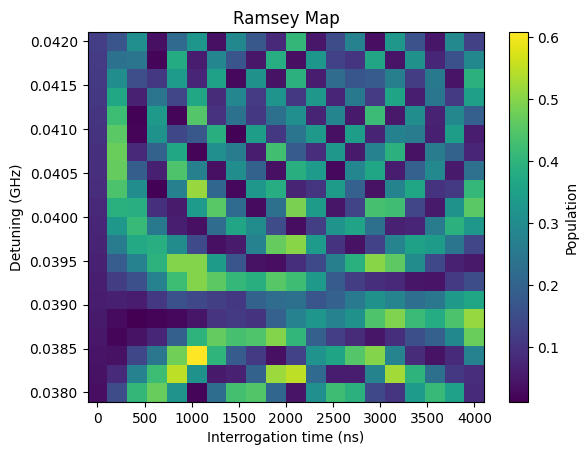

In [46]:
# prompt: Plot exp pcolor map with T and Det as axis


# Assuming T and Det and exp are defined from the previous code block
plt.pcolormesh(T, Det_p, rmap)
plt.xlabel("Interrogation time (ns)")
plt.ylabel("Detuning (GHz)")
plt.title("Ramsey Map")
plt.colorbar(label="Population")
plt.show()

In [3]:
from qubit_zz_coupling.utils import sample_bimodal_gaussian 
import matplotlib.pyplot as plt


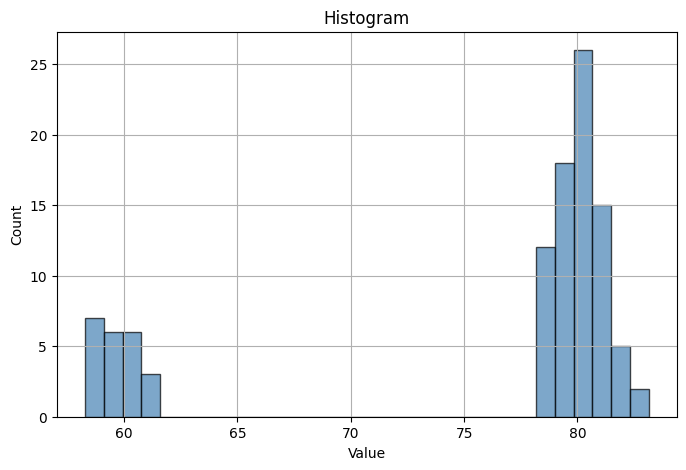

In [ ]:
data = sample_bimodal_gaussian(60,1,80,1,0,100)

# Suppose your list of numbers is called "data"
plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram")
plt.grid(True)
plt.show()